In [1]:
import sys
sys.path.append('./library') # age_gender_predictor
sys.path.append('../.env/lib/python2.7/site-packages')
import os 
import pickle
import age_gender_predictor
from collections import defaultdict
import re
from tabulate import tabulate
from datetime import datetime, timedelta
import math
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
import pytz

## Load Regular User

In [2]:
timezone_location_dict = {
    'Pacific Time (US & Canada)':'US/Pacific',
    'Central Time (US & Canada)':'US/Central',
    'Eastern Time (US & Canada)':'US/Eastern',
    'London':'Europe/London',
    'Sydney':'Australia/Sydney',
    'Tokyo':'Asia/Tokyo',
    'Africa/Nairobi':'Africa/Nairobi',
    'Arizona':'US/Arizona',
    'Kyiv':'Europe/Simferopol',
    'Europe/London':'Europe/London',
    'Atlantic Time (Canada)':'Atlantic/Canary',
    'Midway Island':'Pacific/Apia',
    'Auckland':'Pacific/Auckland',
    'Amsterdam':'Europe/Amsterdam',
    'Baghdad':'Asia/Riyadh',
    'Riyadh':'Asia/Riyadh',
    'Belgrade':'Europe/Belgrade',
    'Quito':'Pacific/Galapagos',
    'Pretoria':'Africa/Johannesburg',
    'Beijing':'Asia/Shanghai',
    'Dublin':'Europe/Dublin',
    'Mountain Time (US & Canada)':'Mountain/US',
    'Hawaii':'Pacific/Honolulu',
    'Brisbane':'Australia/Brisbane',
    'Vienna':'Europe/Vienna',
    'Islamabad':'Asia/Karachi',
    'Casablanca':'Africa/Casablanca',
    'Yakutsk':'Asia/Yakutsk',
    'Tijuana':'America/Tijuana',
    'Johannesburg':'Africa/Johannesburg',
    'Mountain Time (US & Canada)':'US/Central',
    'Bangkok': 'Asia/Bangkok',
    'Harare': 'Africa/Harare',
    'Chennai': 'Asia/Kolkata',
    'Kolkata': 'Asia/Kolkata',
    'Brussels': 'Europe/Brussels',
    'Melbourne': 'Australia/Melbourne',
    'Alaska': 'US/Alaska',
    'Perth': 'Australia/Perth',
    'Denver':'America/Denver',
    'Los Angeles': 'America/Los_Angeles',
    'indiana': 'US/East-Indiana',
    'Vancouver': 'America/Vancouver',
    'Berlin': 'Europe/Berlin',
    'Kentucky': 'America/Kentucky/Louisville',
    'Copenhagen':'Europe/Copenhagen',
    'Athens': 'Europe/Athens',
    'Edinburgh': 'Etc/Greenwich',
    'Wellington': 'Asia/Anadyr',
    'Santiago': 'US/Pacific',
    'America/New_York': 'US/Eastern',
    'Paris': 'Europe/Paris',
    'Jakarta': 'Asia/Jakarta',
    'New Delhi': 'Asia/Calcutta',
    'Chicago': 'US/Central',
    'America/Chicago': 'US/Central',
    'Fiji': 'Pacific/Fiji'
}

def to_local_timezone(local, orig_time):
    dt = datetime.strptime(orig_time, "%Y-%m-%d %H:%M:%S")
    dt = pytz.timezone(local).localize(dt)
    est_dt = dt.astimezone(pytz.timezone('EST'))
    return est_dt

def readTimezone(folder, filename):
    time_dict = {}
    with open(folder + filename, 'r') as openfile:
        for line in openfile.readlines():
            split = line.strip().split('\t')
            if split[2] != 'None':
                time_dict[split[0]] = split[2]
            else:
                continue
    return time_dict

In [3]:
def checkFolderFile(folder):
    return os.listdir(folder)

In [4]:
regular_clean = []
regular_folder = './Regular/'
for regular_file in checkFolderFile(regular_folder):
    regular_clean.append(pd.read_pickle(regular_folder+regular_file))

In [5]:
len(regular_clean)

268

## Load BD

In [6]:
bd_clean = []
bd_folder = './Bipolar/bd_shift2week/'
for bd_file in checkFolderFile(bd_folder):
    bd_clean.append(pd.read_pickle(bd_folder+bd_file))

In [7]:
len(bd_clean)

276

In [8]:
groups = [ regular_clean, bd_clean]
group_names = ["Regular", "Bipolar"]

In [9]:
#Statistics facts of experimental data

headers = ["Group","Users", "Tweets", "Average tweets"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
    tweets_num = sum([timeSeries.shape[0] for timeSeries in group])
    users_num = len(group)
    average_tweets_num = tweets_num / users_num
    contents.append([group_name, users_num, tweets_num, average_tweets_num])
    
print(tabulate(contents, headers=headers))

Group      Users    Tweets    Average tweets
-------  -------  --------  ----------------
Regular      268     58461               218
Bipolar      276    287512              1041


## Age Gender

In [10]:
#Age and gender Distribution
def getAgeGender(group):
    features = {"age":[],"gender":[]}
    for timeSeries in group:
        
        features["age"].append(getAge(timeSeries))
        features["gender"].append(getGender(timeSeries))

    return features
def getAge(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_age(texts)

def getGender(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_gender(texts)

In [11]:
headers = ["Group","Male users", "Female users", "Average age"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
    users_num = float(len(group))
    users_gender = [getGender(timeSeries) for timeSeries in group]
    users_age = [getAge(timeSeries) for timeSeries in group]
    male_ratio = len([gender for gender in users_gender if gender < 0]) / users_num
    female_ratio = 1 - male_ratio
    average_age = sum(users_age) / users_num
    contents.append([group_name, male_ratio, female_ratio, average_age])
print(tabulate(contents, headers=headers))

Group      Male users    Female users    Average age
-------  ------------  --------------  -------------
Regular      0.488806        0.511194        30.1881
Bipolar      0.242754        0.757246        24.4716


## Social

In [12]:
def getTweetRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_tweets / float(total_duration)
    except:
        result = total_tweets / 1.0
    return result

def getLateTweetRate(timeSeries):
    total_late = 0
    for index in timeSeries.index:
        if int(index.hour) <6:
            total_late += 1
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_late / float(total_duration)
    except:
        result = total_late / 1.0
    return result

def getMentionRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    total_mentions = np.sum(seriesContains(timeSeries))
    return total_mentions / float(total_tweets)

def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False

def seriesContains(timeSeries):
    match_function = np.vectorize(thirdPronuonDetect)
    return match_function(timeSeries["text"].str.lower().str.split().values)


def getUniqueMentions(timeSeries):
    total_tweets = timeSeries.shape[0]
    friends_set = set()
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_set.add(word)
    return len(friends_set)

def getFrequentMentions(timeSeries, lowerbound = 3):
    total_tweets = timeSeries.shape[0]
    friends_mentions = {}
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_mentions[word] = friends_mentions.get(word, 0) +1
    frequent_frients = [screen_name for screen_name, mentions in friends_mentions.items() if mentions >= lowerbound]
    return len(frequent_frients)
 

def getSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": [], "late_tweets_rate": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        social_features["late_tweets_rate"].append(getLateTweetRate(timeSeries))
    return social_features

def getAllFeature(group, tail_k = "all"):
    feature_set = {}
    methods = [getSocialFeature_group, getGroupEmotions, getPolarity, getAgeGender]
    for method in methods:
        feature_set.update(method(group.getGroup(tail_k)))
    return feature_set


In [13]:
header = ["tweets_rate", "late_tweets_rate", "mention_rate", "unique_mentions", "frequent_mentions"]
contents = []
for i, group in enumerate(groups):
   
    group_name = group_names[i]
    content = [group_name]
    tweets_rate = np.mean([getTweetRate(timeSeries) for timeSeries in group])
    mention_rate = np.mean([getMentionRate(timeSeries) for timeSeries in group])
    unique_mentions = np.mean([getUniqueMentions(timeSeries) for timeSeries in group])
    frequent_mention = np.mean([getFrequentMentions(timeSeries) for timeSeries in group]) 
    late_tweets_rate = np.mean([getLateTweetRate(timeSeries) for timeSeries in group])
    content += [tweets_rate, late_tweets_rate, mention_rate, unique_mentions, frequent_mention]
    contents.append(content)


print("\n======Mean Distribution======\n")

print(tabulate(contents, headers=header,))


======Mean Distribution======

           tweets_rate    late_tweets_rate    mention_rate    unique_mentions    frequent_mentions
-------  -------------  ------------------  --------------  -----------------  -------------------
Regular        4.26146            0.973105        0.426162            46.6679              9.76866
Bipolar       19.1205             5.98164         0.395342           116.649              37.0399


In [14]:
header = ["tweets_rate", "late_tweets_rate", "mention_rate", "unique_mentions", "frequent_mentions"]
contents = []
for i, timeSeries in enumerate(bd_clean):
    content = [i]
#     content = [timeSeries['name'][0]]
    tweets_rate = getTweetRate(timeSeries)
    mention_rate = getMentionRate(timeSeries)
    unique_mentions = getUniqueMentions(timeSeries)
    frequent_mention = getFrequentMentions(timeSeries)
    late_tweets_rate = getLateTweetRate(timeSeries)
    content += [tweets_rate, late_tweets_rate, mention_rate, unique_mentions, frequent_mention]
    contents.append(content)
print("\n======Mean Distribution======\n")
print(tabulate(contents, headers=header,))


======Mean Distribution======

       tweets_rate    late_tweets_rate    mention_rate    unique_mentions    frequent_mentions
---  -------------  ------------------  --------------  -----------------  -------------------
  0     148.39              55.9819         0.658435                  536                  315
  1       0.8917             0.265613       0.93617                    25                    8
  2       6.83891            0.0911854      0.656                     121                   15
  3     151.628             53.2354         0.562411                 1550                  437
  4       6.69145            0.160595       0.666667                  113                   17
  5       2.82876            1.29874        0.150943                   19                    4
  6       7.40528            5.1223         0.30829                    32                   13
  7      52.287              6.14934        0.191532                  321                   44
  8       3.23417 

## Polarity Feature

In [15]:
def getFlipsCount(timeSeries, upperbound=120, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )

def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def getFlipsDuration(timeSeries, flips):
    filtered_timeSeries = timeSeries['dt'][flips].index.values
    dt = np.zeros(filtered_timeSeries.shape[0],dtype=float)
    dt[:-1] = (filtered_timeSeries[1:] - filtered_timeSeries[:-1]).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return dt

def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit in combos if element == matcher and hit > lowerbound])
    return combos_count

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / float(total_tweets)

def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / float(total_tweets)

def getPolarity(group):
    polarity = {"flips":[],"negative_combos":[],"positive_combos":[], "positive_ratio":[], "negative_ratio":[]}
    for timeSeries in group:
        try:
            tweets_length = float(timeSeries.shape[0])
        except:
            print 'error'
            print timeSeries
            break
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos_ratio = getCombosCount(timeSeries,matcher=-1) / tweets_length
        positive_combos_ratio = getCombosCount(timeSeries,matcher=1) / tweets_length
        positive_ratio = getPositiveRatio(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        
        polarity["flips"].append(flips_ratio)
        polarity["negative_combos"].append(negative_combos_ratio)
        polarity["positive_combos"].append(positive_combos_ratio)
        polarity["positive_ratio"].append(positive_ratio)
        polarity["negative_ratio"].append(negative_ratio)
        
    return polarity

def comboTracker(timeSeries, attribute= "polarity", lowerbound = 120):
    array = timeSeries[attribute]
#     the polarity of starter
    starter = array[0]
    combo = 1
    result = []
    i = 0 
#     begin from second one in the array
    for cursor in array[1:]:
        i += 1
        if starter == cursor and timeSeries["dt"][i-1] < lowerbound:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result

In [16]:
headers = ["Group","Positive Ratio","Negative Ratio", "Flip Ratio", "Positive Combos", "Negative Combos"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
   
    positive_ratio_mean = np.mean([getPositiveRatio(timeSeries) for timeSeries in group])
    negative_ratio_mean = np.mean([getNegativeRatio(timeSeries) for timeSeries in group])
    flips_ratio_mean = np.mean([getFlipsCount(timeSeries) / float(len(timeSeries)) for timeSeries in group])
    negative_combos_ratio = np.mean([getCombosCount(timeSeries,matcher=-1) / float(len(timeSeries)) for timeSeries in group])
    positive_combos_ratio = np.mean([getCombosCount(timeSeries,matcher=1) / float(len(timeSeries)) for timeSeries in group])
    
    contents.append([group_name, positive_ratio_mean, negative_ratio_mean, flips_ratio_mean, positive_combos_ratio, negative_combos_ratio])
print("\n=========\n")
print(tabulate(contents, headers=headers))



Group      Positive Ratio    Negative Ratio    Flip Ratio    Positive Combos    Negative Combos
-------  ----------------  ----------------  ------------  -----------------  -----------------
Regular         0.223516           0.107087    0.00397308         0.0307636          0.00364134
Bipolar         0.0844575          0.176278    0.00597603         0.00616584         0.0246394


In [17]:
headers = ["Group","Positive Ratio Mean","Positive Ratio STD", "Negative Ratio Mean", "Negative Ratio STD"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
   
    positive_ratios = [getPositiveRatio(timeSeries) for timeSeries in group]
    negative_ratios = [getNegativeRatio(timeSeries) for timeSeries in group]
    positive_ratio_mean = np.mean(positive_ratios)
    negative_ratio_mean = np.mean(negative_ratios)
    positive_ratio_std = np.std(positive_ratios)
    negative_ratio_std = np.std(negative_ratios)

    contents.append([group_name, positive_ratio_mean, positive_ratio_std, negative_ratio_mean, negative_ratio_std])
print("\n=========\n")
print(tabulate(contents, headers=headers))



Group      Positive Ratio Mean    Positive Ratio STD    Negative Ratio Mean    Negative Ratio STD
-------  ---------------------  --------------------  ---------------------  --------------------
Regular              0.223516              0.156083                0.107087             0.0834606
Bipolar              0.0844575             0.0639484               0.176278             0.100146


## Emotion

In [18]:
def getUsersEmotions(timeSeries):
    non_ambiguous = np.invert(timeSeries["ambiguous"].values)
    
    filtered_emotions = timeSeries["emotion"][non_ambiguous].values
    emotions_count = {"joy":0,"sadness": 0,"fear":0,\
                "anticipation": 0, "anger":0, "trust": 0, "disgust": 0 ,"surprise" : 0}
    if float(filtered_emotions.shape[0]) == 0:
        divider = 1.0
    else:
        divider = float(filtered_emotions.shape[0])
    for emotion in emotions_count:
        emotions_count[emotion] = np.sum(filtered_emotions == emotion) / divider
    return emotions_count

def getGroupEmotions(group):
    emotions_counts = {"joy":[],"sadness": [],"fear":[],\
                "anticipation": [], "anger":[], "trust": [], "disgust": [] ,"surprise" : []}
    for timeSeries in group:
        emotions_count = getUsersEmotions(timeSeries)
        for emotion, count in emotions_count.items():
            emotions_counts[emotion].append(count)
    return emotions_counts



In [19]:
emotions = ["joy","sadness","fear", "anticipation", "anger", "trust", "disgust" ,"surprise"]

headers = ["Group"] + emotions
contents = []
for i, group in enumerate(groups):
   
    group_name = group_names[i]
    content = [group_name]
    emotions_counts = getGroupEmotions(group)
    for emotion in emotions:
        emotion_ratio = "{}%".format(round(np.mean(emotions_counts[emotion])*100, 2))
        
        content.append(emotion_ratio)
    contents.append(content)
    
print("\n======Eight Emotional Features======\n")

print("\n======Distribution======\n")

print(tabulate(contents, headers=headers,))



======Eight Emotional Features======


======Distribution======

Group    joy     sadness    fear    anticipation    anger    trust    disgust    surprise
-------  ------  ---------  ------  --------------  -------  -------  ---------  ----------
Regular  16.36%  26.24%     6.46%   14.26%          6.82%    15.1%    11.52%     3.24%
Bipolar  13.83%  26.53%     6.05%   12.47%          10.44%   6.75%    14.65%     9.28%


## Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib import rcParams
from random import randint
from operator import itemgetter 
import time
rcParams['figure.figsize'] = 12, 8

In [21]:
#Wrap group to be object
class Group(object):
    def __init__(self, group_name, group_data_list):
        self.name = group_name
        self.timeSerieses_list = group_data_list
        
    def getName(self):
        return self.name
    
    def getSize(self):
        return len(self.timeSerieses_list)
    
    def getGroup(self, tail_k="all"):
        if tail_k =="all":
            return self.timeSerieses_list
        else:
            return [timeSeries.tail(tail_k) for timeSeries in self.group]

In [22]:
bipolar_group = Group("Bipolar", bd_clean)
regular_group = Group("Regular", regular_clean)

In [23]:
def getCategories(group):
    name2category = {}
    names = ["Social", "Emotions", "Polarity", "AgeGender"]
    methods = [getSocialFeature_group, getGroupEmotions, getPolarity, getAgeGender]
    for i, method in enumerate(methods):
        feature = method(group.getGroup())
        for key in feature:
            name2category[key] = names[i]
    return name2category

In [24]:
class POLFeaturerGroups(object):
    
    @staticmethod
    def transform(self, ):
        features_dict = getAllFeature(group)
        
    
    def __init__(self, base, groups):
        feature2categories = getCategories(base)
        self.groups = groups
        self.base = base
        self.categories = set(feature2categories.values())
        self.name_to_index = {group.getName(): index for index, group in enumerate(groups)}
        self.base_name = base.getName()
        self.index2feature = []
        base_feature_dict = getAllFeature(base)
        self.base_feature = np.zeros((base.getSize(),len(base_feature_dict)), dtype = float)
        for name, values in base_feature_dict.items():
            cursor = len(self.index2feature)
          
            self.base_feature[:,cursor] = values
            category = feature2categories[name]
            self.index2feature.append((name, category))
        
        
        self.features = [self.group2feature(group) for group in groups]
#         user_name
        self.groups_user_name = []
        for group in groups:
            group_user_name = []
            for timeSeries in group.getGroup():
                group_user_name.append(timeSeries['name'][0])
            self.groups_user_name.append(group_user_name)
        
        self.base_user_name = []
        for timeSeries in base.getGroup():
            self.base_user_name.append(timeSeries['name'][0])
        
    def group2feature(self, group, tail_k="all", selection = "all"):
        features_dict = getAllFeature(group, tail_k)
        feature = np.zeros((group.getSize(),len(self.index2feature)),dtype=float)
        for cursor, (name,category) in enumerate(self.index2feature):
            value = features_dict[name]
            feature[:,cursor] = value
        if selection == "all":
            return feature
        else:
            return feature[:,selection]   

    def getPrecision(self,name,selection="all",tail_k="all",n_fold=10,classifier = "forest"):
        complete_X, Y = self.getLabeledData(name, selection)
        index = self.name_to_index[name]
        group = self.groups[index]
        tailed_X = preprocessing.scale(self.group2feature(self.base + group, tail_k=tail_k, selection = selection))
        complete_X = preprocessing.scale(complete_X)
        
        tailed_X[np.isinf(tailed_X)] = 0
        tailed_X[np.isnan(tailed_X)] = 0
        
        precisions = []
        if classifier == "forest":
            classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
  
        sss = StratifiedShuffleSplit(Y, n_fold, test_size = 0.4, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            X_train, X_test = complete_X[train_index], tailed_X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            imputer = Imputer()
            classifier.fit(X_train, Y_train)
            score = classifier.score(X_test,Y_test)
            precisions.append(score)
            
        return np.mean(precisions)
            
    def getLabeledData(self,name, selection = "all"):
        if selection is "all":
            selection = range(len(self.index2feature))
        
        base_feature = self.base_feature[:,selection]
        base_length = base_feature.shape[0]
        index = self.name_to_index[name]
        feature = self.features[index][:,selection]

        X = np.zeros((base_length  + feature.shape[0],len(selection)),dtype=float)
        X[0:base_length ,:] = base_feature
        X[base_length:,:] = feature
#         Y = np.array([(0,-1)]*base_length + [(1,i) for i,_ in enumerate(self.getGroupUserName())])
        Y = np.array([(0,i) for i,_ in enumerate(self.getBaseUserName())] + [(1,i) for i,_ in enumerate(self.getGroupUserName())])
        
        return X, Y
    
    def getFeatureImportance_all(self,name):
        X, Y = self.getLabeledData(name)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        features_indicies = np.argsort(classifier.feature_importances_)
        feature_names = [self.index2feature[i] for i in features_indicies ]
        return feature_names[::-1]
    
    def getFeature(self, name, selection="all"):
        if selection is "all":
            selection = list(range(len(self.index2feature)))
        index = self.name_to_index[name]
        feature =  self.features[index]
        return feature[:, selection]
    
    def classify(self,name, target_name, selection="all"):
        X, Y = self.getLabeledData(name, selection)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        test_x = self.getFeature(target_name,selection)
        return classifier.predict(test_x)
       
    def getLabelsScores(self, name, classifier, n_fold, selection):
        SCORES = np.array([])
        LABELS = np.zeros(shape=(0,2))
        X, Y = self.getLabeledData(name, selection)        
        sss = StratifiedShuffleSplit(Y[:,0], n_fold, test_size = 0.4, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            X_train, X_test           = X[train_index], X[test_index]
            Y_train, Y_test           = Y[train_index][:,0], Y[test_index][:,0]
            Y_train_name, Y_test_name = Y[train_index][:,1], Y[test_index][:,1]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y[test_index]))
        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test, Y_train_name, Y_test_name)
    
    def renderPrecisionRecall_all(self, name,colors=['r','g','b',"y", "m"], n_fold = 100):
        classifier  = RandomForestClassifier(n_jobs= -1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x')
        ax.tick_params(axis='y')
        ax.title.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve: {}'.format(name))
        
        categories = list(self.categories) + ["All"]
        for g,category in enumerate(categories):
            if category == "All":
                selection = range(len(self.index2feature))
            else:
                selection = [i for i, (feature_name, feature_category) in enumerate(self.index2feature) if category == feature_category]
            
            SCORES, LABELS, (X_train, X_test,Y_train, Y_test, Y_train_name, Y_test_name) = self.getLabelsScores(name, classifier,n_fold, selection)
            precision, recall, _ = precision_recall_curve(LABELS[:,0], SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS[:,0], SCORES)
            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test
           
            plt.plot(recall, precision, label=category , color=colors[g],linewidth=2)
            
        print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,name))
        print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,name))
        plt.legend(loc="lower right")
        plt.show()

    def getSeperateScores(self, name, classifier, n_fold, selection):
        SCORES = np.array([])
        LABELS = np.array([])

        X, Y = self.getLabeledData(name, selection)

        sss = StratifiedShuffleSplit(Y, n_fold, test_size = 0.4, random_state=randint(0,65536) )

        for train_index, test_index in sss:

            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))

        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test)
    
    def getGroupUserName(self,group_num = 0):
        return self.groups_user_name[group_num]
    
    def getIndex2Feature(self):
        return self.index2feature
    
    def getBaseUserName(self):
        return self.base_user_name

In [25]:
pol_groups = POLFeaturerGroups(regular_group, [bipolar_group])

161 Normal and 165 Bipolar in Training Data
107 Normal and 111 Bipolar in Test Data



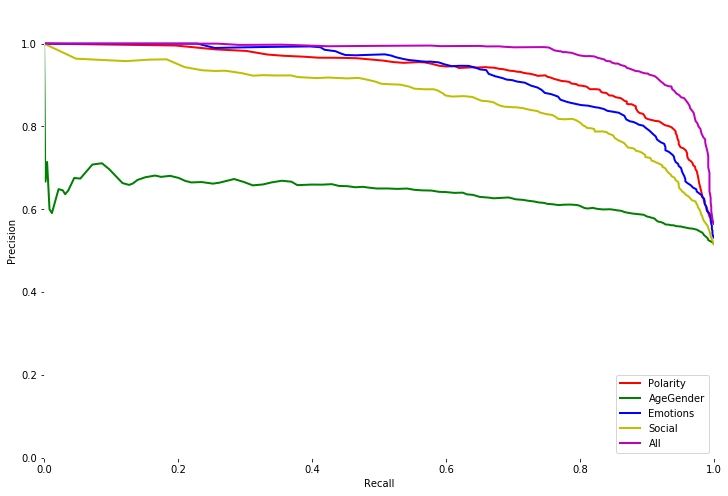

In [26]:
#Compare the performance of each Pattern of Life components and LIWC
pol_groups.renderPrecisionRecall_all("Bipolar",n_fold=10)

# Precission Recall Chart on 10-fold cross-validation

Pattern of Life under curve area: 0.976347141534


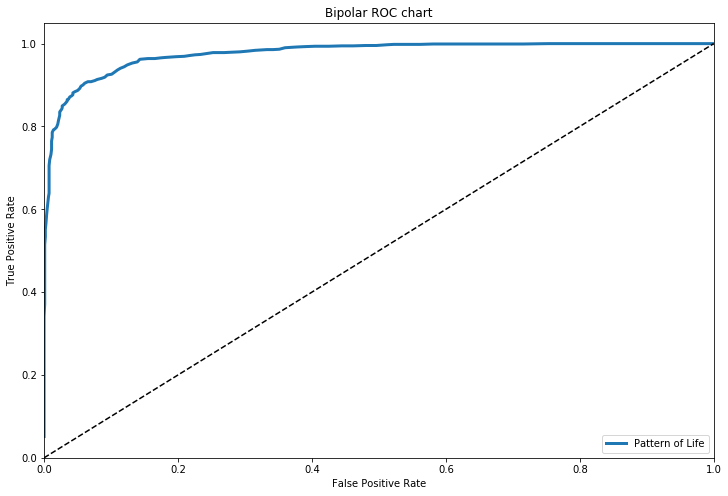

Pattern of Life Average Precision: 0.978811543626


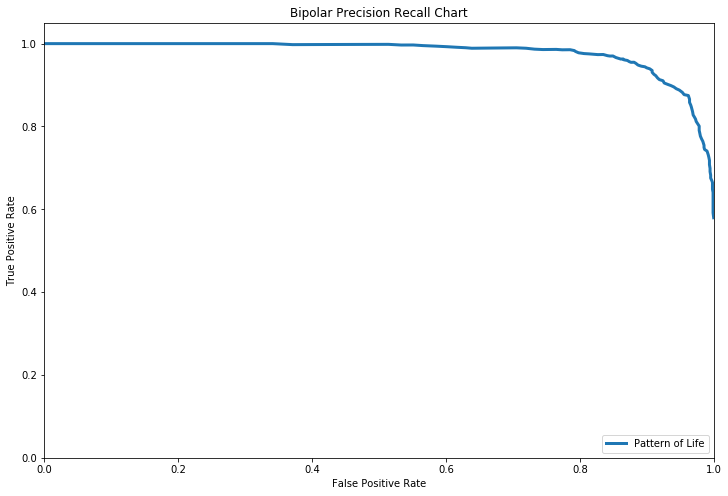

In [27]:
 
index2feature = pol_groups.index2feature

def getSelection(excluded_categories=[], excluded_index=[]):
    selection = []
    for i in range(len(index2feature)):
        name,category =  index2feature[i]
        if any(category == x for x in excluded_categories):
            #removed_features.append(name)
            pass
        elif any(name == x for x in excluded_index):
            #removed_features.append(name)
            pass

        else:                   
            selection.append(i)
    return selection


POL_selection = getSelection(excluded_categories=["LIWC"])

#ROC chart of three models:
def renderROC(scores, labels,disorder ,names, linestyle=['solid','dashed','dotted']):
    fig, ax = plt.subplots()
    for i,(score, label) in enumerate(zip(scores, labels)):
        fpr, tpr, _ = roc_curve(label,score, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=names[i], ls=linestyle[i],linewidth=3)
        print("{} under curve area: {}".format(names[i],roc_auc))

   
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()

names = ["Pattern of Life"]
classifier  = RandomForestClassifier(n_jobs= -1, max_features="sqrt", n_estimators=128)
name = "Bipolar"
n_fold = 10
POL_scores, POL_labels, _ = pol_groups.getLabelsScores(name, classifier, n_fold=n_fold, selection=POL_selection)

bipolar_SCORES = [POL_scores]
bipolar_LABELS = [POL_labels[:,0]]
bipolar_NAMES = [POL_labels[:,1]]


renderROC(bipolar_SCORES, bipolar_LABELS, name,names)

POL_scores, POL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=POL_selection)

#np.sum(tfidf_labels)

def renderPRC(scores, labels,disorder ,names, linestyle=['solid','dashed','dashdot']):
    fig, ax = plt.subplots()
    for i,(score, label) in enumerate(zip(scores, labels)):
        
        precision, recall, _ = precision_recall_curve(label, score, pos_label=1)
        average_precision = average_precision_score(label, score)

        plt.plot(recall, precision, label=names[i], ls=linestyle[i],linewidth=3)
        print("{} Average Precision: {}".format(names[i],average_precision))

   

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Precision Recall Chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()
    
renderPRC(bipolar_SCORES, bipolar_LABELS, "Bipolar",names)

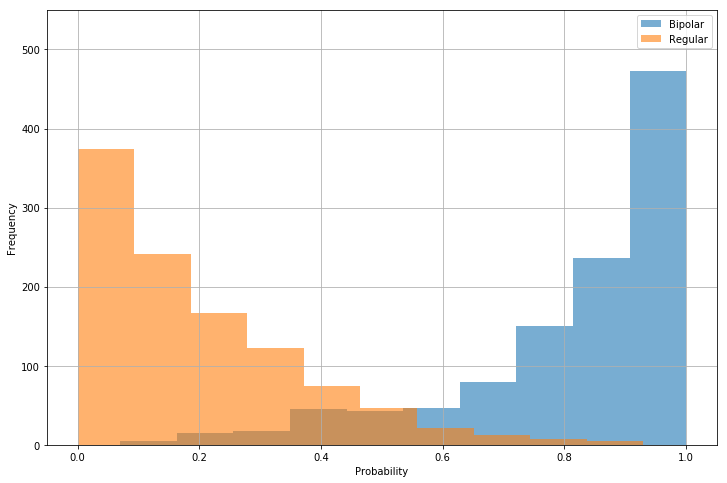

In [28]:
bipolar_index = [i for i, value in enumerate(bipolar_LABELS[0]) if value == 1]

bipolar_value = [bipolar_SCORES[0][i] for i in bipolar_index]

regular_value = [bipolar_SCORES[0][i] for i in range(len(bipolar_SCORES[0])) if i not in bipolar_index]

plt.hist(bipolar_value, label = 'Bipolar', alpha=0.6)
plt.hist(regular_value, label = 'Regular', alpha=0.6)

plt.grid(True)
plt.xlabel("Probability")
plt.ylabel("Frequency")

plt.ylim([0, 550])
plt.legend() 
plt.show() 
plt.close()

In [29]:
b_P_list = []
b_R_list = []
r_p_list = []
r_R_list = []
thre_list = np.arange(0.4,0.91,0.001)
for thre in thre_list:

    bipolar_index = [i for i, value in enumerate(bipolar_LABELS[0]) if value == 1]

    bipolar_value = [bipolar_SCORES[0][i] for i in bipolar_index]

    TP_bipolar_value = filter(lambda x: x >= thre, bipolar_value)

    regular_value = [bipolar_SCORES[0][i]for i in range(len(bipolar_SCORES[0])) if i not in bipolar_index]

    TN_regular_value = filter(lambda x: x < thre, regular_value)

    Total_Bipolar = len(bipolar_value)

    Total_Regular = len(regular_value)

    FP = Total_Regular - len(TN_regular_value)

    FN = Total_Bipolar - len(TP_bipolar_value)

    b_P = float(len(TP_bipolar_value))/(len(TP_bipolar_value) + FP)
    b_R = float(len(TP_bipolar_value))/len(bipolar_value)
    r_p = float(len(TN_regular_value))/(len(TN_regular_value) + FN)
    r_R = float(len(TN_regular_value))/len(regular_value)

    b_P_list.append(b_P)
    b_R_list.append(b_R)
    r_p_list.append(r_p)
    r_R_list.append(r_R)


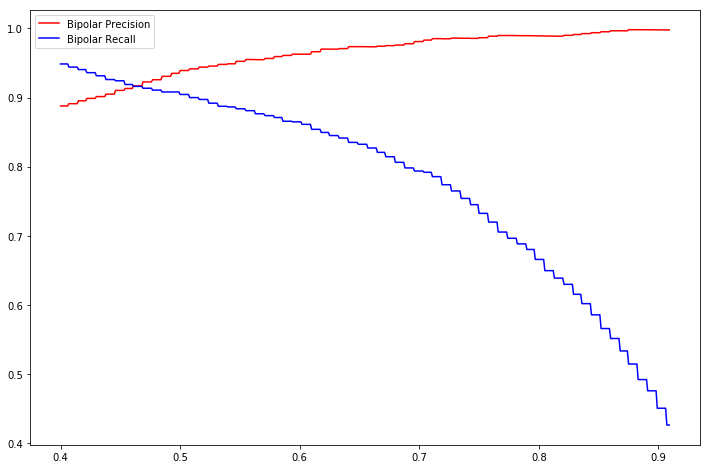

In [30]:
plt.plot(thre_list, b_P_list, 'r', label='Bipolar Precision')
plt.plot(thre_list, b_R_list, 'b', label='Bipolar Recall')
plt.legend()
plt.show() 
plt.close()

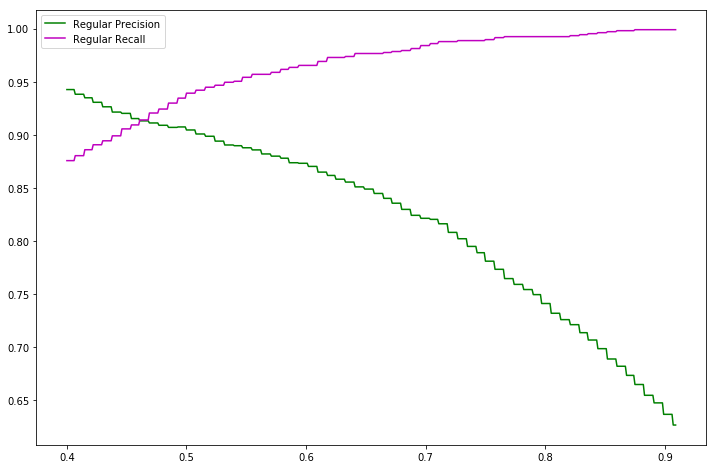

In [31]:
plt.plot(thre_list, r_p_list, 'g', label='Regular Precision')
plt.plot(thre_list, r_R_list, 'm', label='Regular Recall')
plt.legend()
plt.show() 
plt.close()

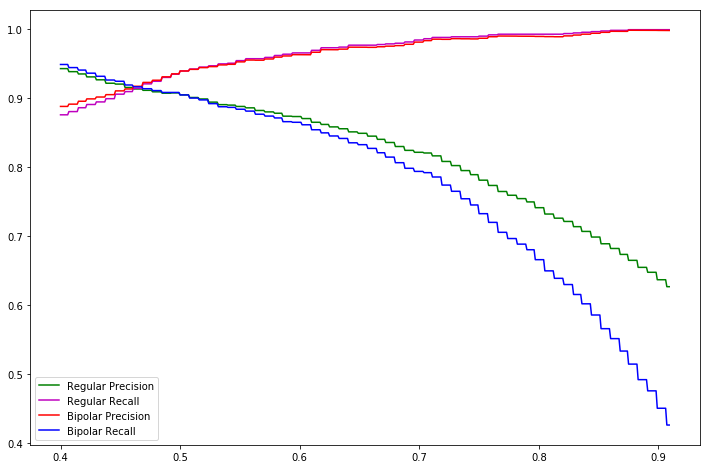

In [32]:
plt.plot(thre_list, r_p_list, 'g', label='Regular Precision')
plt.plot(thre_list, r_R_list, 'm', label='Regular Recall')
plt.plot(thre_list, b_P_list, 'r', label='Bipolar Precision')
plt.plot(thre_list, b_R_list, 'b', label='Bipolar Recall')
plt.legend()
plt.show() 
plt.close()

In [34]:
for i, value in enumerate(thre_list):
    if b_P_list[i] < r_R_list[i]:
        cross_i = i
        upper_bound = thre_list[i]
        print upper_bound
        break
for i, value in enumerate(thre_list):
    if r_p_list[i] < b_P_list[i]:
        
        lower_bound = thre_list[i]
        print lower_bound
        break

0.5
0.461


Bipolar Precision: 0.939195509822
Bipolar Recall: 0.904504504505


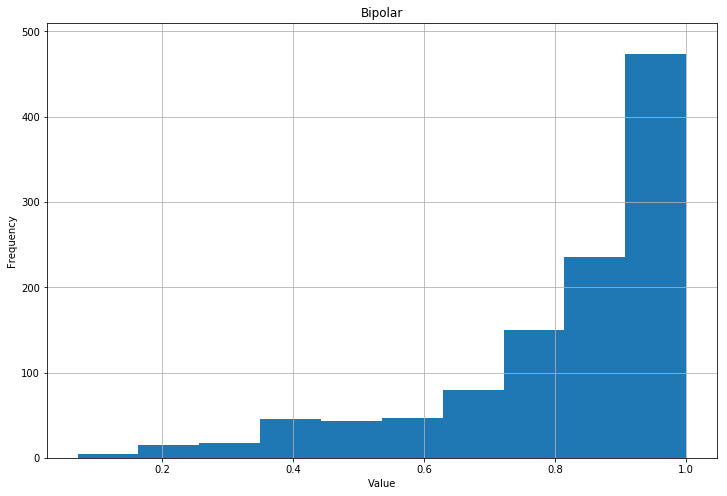

Regular Precision: 0.904590459046
Regular Recall: 0.939252336449


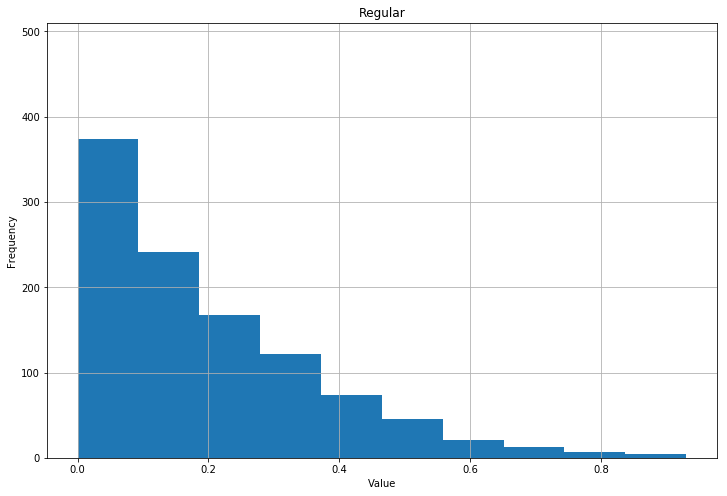

In [35]:
print('Bipolar Precision: {}'.format(b_P_list[cross_i]))
print('Bipolar Recall: {}'.format(b_R_list[cross_i]))
plt.hist(bipolar_value)
plt.grid(True)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Bipolar")
plt.ylim([0, 510])
# plt.xlim([0.4, 0.9])
plt.show()
plt.close()

print('Regular Precision: {}'.format(r_p_list[cross_i]))
print('Regular Recall: {}'.format(r_R_list[cross_i]))
plt.hist(regular_value)
plt.grid(True)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Regular")
plt.ylim([0, 510])
# plt.xlim([0.4, 0.9])
plt.show() 
plt.close()

Bipolar Precision: 0.915223336372
Bipolar Recall: 0.939195509822

Regular Precision: 0.937679769895
Regular Recall: 0.913165266106


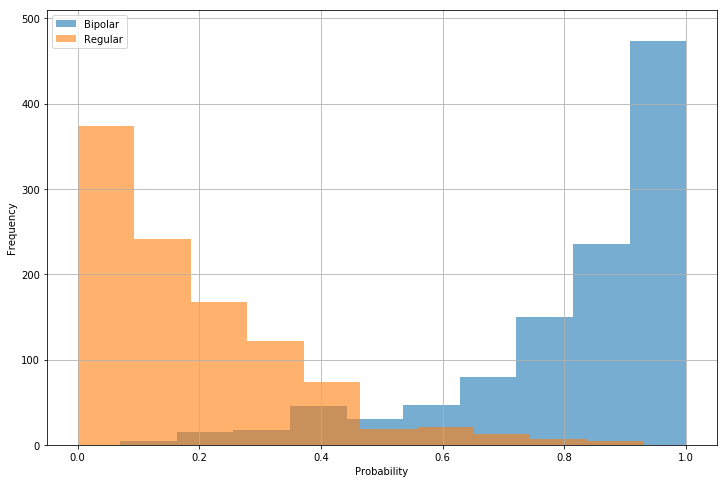

In [36]:
# Cut in different value

bipolar_index = [i for i, value in enumerate(bipolar_LABELS[0]) if value == 1]

bipolar_value = [bipolar_SCORES[0][i] for i in bipolar_index]

TP_bipolar_value = filter(lambda x: x >= upper_bound, bipolar_value)

regular_value = [bipolar_SCORES[0][i] for i in range(len(bipolar_SCORES[0])) if i not in bipolar_index]

TN_regular_value = filter(lambda x: x < lower_bound, regular_value)

FP = len(filter(lambda x: x < lower_bound, bipolar_value))

FN = len(filter(lambda x: x >= upper_bound, regular_value))

b_P = float(len(TP_bipolar_value))/(len(TP_bipolar_value) + FP)
b_R = float(len(TP_bipolar_value))/(len(TP_bipolar_value)+FN )
r_p = float(len(TN_regular_value))/(len(TN_regular_value) + FN)
r_R = float(len(TN_regular_value))/(len(TN_regular_value)+ FP)

print('Bipolar Precision: {}'.format(b_P))
print('Bipolar Recall: {}'.format(b_R))
print 
print('Regular Precision: {}'.format(r_p))
print('Regular Recall: {}'.format(r_R))

plt.hist(filter(lambda x: x >= upper_bound or x < lower_bound, bipolar_value), label = 'Bipolar', alpha=0.6)
plt.hist(filter(lambda x: x >= upper_bound or x < lower_bound, regular_value), label = 'Regular', alpha=0.6)

plt.grid(True)
plt.xlabel("Probability")
plt.ylabel("Frequency")

plt.ylim([0, 510])
plt.legend() 
plt.show() 
plt.close()

# Check Polarity user

In [37]:
from collections import Counter

In [52]:
under_lower_index = [i for i in bipolar_index if bipolar_SCORES[0][i] < lower_bound]
under_lower_user = [(pol_groups.getGroupUserName()[int(bipolar_NAMES[0][i])], bipolar_SCORES[0][i]) for i in under_lower_index]
# Counter([name for name, value in under_lower_user]).most_common()


## BD user Predict < 0.3

In [53]:
Counter([name for name, value in filter(lambda x: x[1]<0.3 ,under_lower_user)]).most_common()

[('enjoyscarlett_', 6),
 ('Megrrrs', 5),
 ('TommmMate', 4),
 ('AndrewHoughton8', 3),
 ('Boricua611', 2),
 ('yohaw', 2),
 ('clyder1966', 2),
 ('_kenziiieee_', 1),
 ('Radica_XO_Khidd', 1)]

## Regular user Predict > 0.7

In [49]:
regular_index = [i for i in xrange(len(bipolar_SCORES[0])) if i not in bipolar_index]
on_upper_index = [i for i in regular_index if bipolar_SCORES[0][i] > upper_bound]
on_upper_user = [(pol_groups.getBaseUserName()[int(bipolar_NAMES[0][i])], bipolar_SCORES[0][i]) for i in regular_index]
# Counter([name for name, value in on_upper_user]).most_common()


In [50]:
Counter([name for name, value in filter(lambda x: x[1]>0.7 ,on_upper_user)]).most_common()

[(1648646648, 5),
 (453767970, 3),
 (356860297, 3),
 (2847673069, 2),
 (118151476, 2),
 (258224151, 1),
 (2922189332, 1)]

## Testing Predict Model

In [42]:
def getPOLFeature(timeSeries):
#     features = np.zeros((len(user_timeSeries_list),20),dtype=float)
    features = np.zeros((20),dtype=float)
        
    tweets_length = float(timeSeries.shape[0])
    tweets_rate = getTweetRate(timeSeries)
    late_tweets_rate = getLateTweetRate(timeSeries)
    mention_rate = getMentionRate(timeSeries)
    unique_mentions = getUniqueMentions(timeSeries)
    frequent_mentions = getFrequentMentions(timeSeries)
    negative_ratio = getNegativeRatio(timeSeries)
    positive_ratio = getPositiveRatio(timeSeries)
    flips_ratio = getFlipsCount(timeSeries) / tweets_length
    negative_combos = getCombosCount(timeSeries,matcher=-1) / tweets_length
    positive_combos = getCombosCount(timeSeries,matcher=1) / tweets_length
    emotion_counts_dict = getUsersEmotions(timeSeries)


    age = getAge(timeSeries)
    gender = getGender(timeSeries)

    features[0] = tweets_rate
    features[1] = late_tweets_rate
    features[2] = mention_rate
    features[3] = unique_mentions
    features[4] = frequent_mentions 
    features[5] = positive_ratio
    features[6] = negative_ratio
    features[7] = flips_ratio
    features[8] = negative_combos
    features[9] = positive_combos
    features[10] = age
    features[11] = gender
    for j, emotion in enumerate(["joy","sadness","fear", "anticipation", "anger", "trust", "disgust" ,"surprise"]):
        features[12+j] = np.mean(emotion_counts_dict[emotion])
        
            
    return features

In [55]:
# #Dump the pre-trained models

# # Get feature
feature_order = ['tweets_rate', 'late_tweets_rate','mention_rate','unique_mentions','frequent_mentions','positive_ratio',\
                 'negative_ratio','flips','negative_combos','positive_combos', 'age', 'gender', "joy","sadness","fear",  \
                 "anticipation", "anger", "trust", "disgust" ,"surprise" ]
online_selection = []

for feature_name in feature_order:
    for i,(name, category) in enumerate(pol_groups.index2feature):
        if name == feature_name:
            online_selection.append(i)
print(online_selection)
            
classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)

X, Y = pol_groups.getLabeledData("Bipolar", selection=online_selection)
classifier = classifier.fit(X,Y)

# joblib.dump(classifier,"models/bipolar_forest/bipolar_forest_2week_modified")


[7, 18, 10, 3, 17, 6, 0, 8, 19, 2, 5, 12, 4, 9, 15, 1, 13, 16, 11, 14]


## Check the Feature Order

In [44]:
for cursor, (name,category) in enumerate(pol_groups.getIndex2Feature()):
    print '{}\t{}\t{}'.format(cursor, name, category)

0	negative_ratio	Polarity
1	anticipation	Emotions
2	positive_combos	Polarity
3	unique_mentions	Social
4	joy	Emotions
5	age	AgeGender
6	positive_ratio	Polarity
7	tweets_rate	Social
8	flips	Polarity
9	sadness	Emotions
10	mention_rate	Social
11	disgust	Emotions
12	gender	AgeGender
13	anger	Emotions
14	surprise	Emotions
15	fear	Emotions
16	trust	Emotions
17	frequent_mentions	Social
18	late_tweets_rate	Social
19	negative_combos	Polarity


In [62]:
SCORES = np.array([])
#         LABELS = np.array([[]])
LABELS = np.zeros(shape=(0,2))

X, Y = pol_groups.getLabeledData("Bipolar", online_selection)

sss = StratifiedShuffleSplit(Y[:,0], 1, test_size = 0.4, random_state=randint(0,65536) )

for train_index, test_index in sss:

    X_train, X_test           = X[train_index], X[test_index]
    Y_train, Y_test           = Y[train_index][:,0], Y[test_index][:,0]
    Y_train_name, Y_test_name = Y[train_index][:,1], Y[test_index][:,1]

#     classifier.fit(X_train, Y_train)
#     score = classifier.predict_proba(X_test)[:,1]
    score = classifier.predict_proba(X_test)[0][:,1]
    SCORES = np.concatenate((SCORES, score))
    LABELS = np.concatenate((LABELS, Y[test_index]))


## Check Testing Result

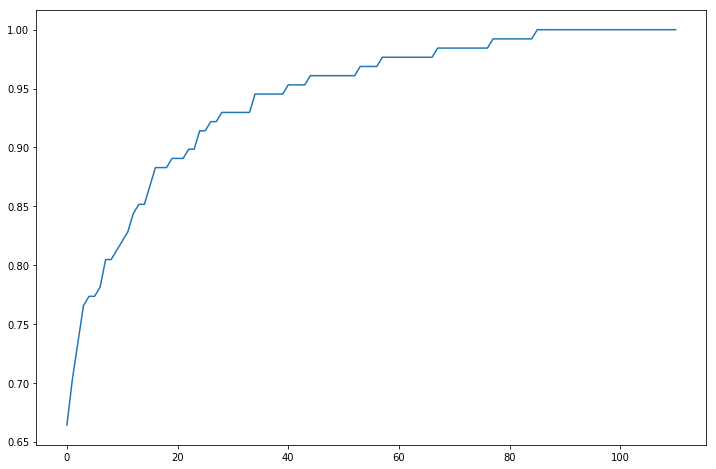

In [63]:
bd_testing_list = []
for i, lab in enumerate(LABELS):
    if lab[0] == 1:
        bd_testing_list.append(SCORES[i])
plt.plot(sorted(bd_testing_list))
plt.show()
plt.close()    

## Check Training Result

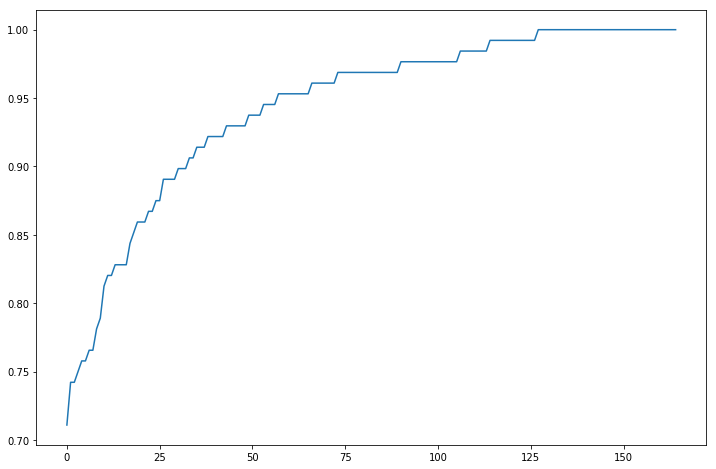

In [65]:
bd_testing_list = []
train_score = classifier.predict_proba(X_train)[0][:,1]
for i, lab in enumerate(Y[train_index]):
    if lab[0] == 1:
        bd_testing_list.append(train_score[i])
plt.plot(sorted(bd_testing_list))
plt.show()
plt.close()   

## Check Original BD user Dataset

In [66]:
# proba_list = []
# for timeSeries in bd_clean:
#     bd_features = getPOLFeature(timeSeries)
#     bd_proba = classifier.predict_proba(bd_features)[0][1]
#     proba_list.append(bd_proba)
    
# plt.plot(sorted(proba_list))
# plt.show()
# plt.close()
